In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from qdrant_client import QdrantClient
from qdrant_client.http import models
import json

tab = pd.read_csv("pkm.csv")
tab

,id,description,nom,type
0,1,"Au matin de sa vie, la graine sur\r\nson dos l...",Bulbizarre,Pokémon Graine
1,1,Il a une étrange graine plantée sur son dos.\r...,Bulbizarre,Pokémon Graine
2,1,"Au matin de sa vie, la graine sur son dos lui ...",Bulbizarre,Pokémon Graine
3,1,Bulbizarre passe son temps à faire la sieste s...,Bulbizarre,Pokémon Graine
4,1,Il peut survivre plusieurs jours sans manger\r...,Bulbizarre,Pokémon Graine
...,...,...,...,...
1396,151,Nombre de scientifiques voient en\r\nlui l’anc...,Mew,Pokémon Nouveau
1397,151,Nombre de scientifiques voient en lui l’ancêtr...,Mew,Pokémon Nouveau
1398,151,Son ADN contient les codes génétiques de tous\...,Mew,Pokémon Nouveau
1399,151,On dit que Mew possède le code génétique de to...,Mew,Pokémon Nouveau


In [2]:
def embed(
    text,
    ollama = "http://ollama:11434/api",
    model = "bge-m3:567m-fp16",
):
    response = requests.post(
        ollama + "/embeddings",
        json = {
            "model": model,
            "prompt": text,
        }
    )
    return response.json()["embedding"]

def query(text, client, collection, k = 5):
    search_results = client.query_points(
        collection_name=collection,
        query = embed(text),
        limit=k
    )
    
    for i, result in enumerate(search_results.points, 1):
        print(f"\n[Result #{i}] ID: {result.id} | Score: {result.score:.3f}")
        print(json.dumps(result.payload, indent=2, ensure_ascii=False))
        print(f"{'-'*50}")

In [3]:
client = QdrantClient("qdrant", port=6333)
client.delete_collection(collection_name="pokemons")
client.create_collection(
    collection_name="pokemons",
    vectors_config=models.VectorParams(
        size= 1024,
        distance=models.Distance.COSINE
    )
)
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='pokemons')])

In [4]:
verbose = [1,4,7,25,151]
for id in tab["id"].unique():
    
    tmp = tab[tab["id"] == id]
    nom = tmp["nom"].iloc[0]
    type = tmp["type"].iloc[0]
    description = ""
    for j in range(len(tmp)):
        description = description + tmp["description"].iloc[j] + " "
    description = description.replace("\r", "").replace("\n", " ")
    prompt = nom + " est un " + type + ". " + description

    if id in verbose:
        print(prompt + "\n\n")

    # prompt_en = translate(prompt_fr)
    #
    # if id in verbose:
    #    print(prompt_en + "\n\n")

    vector = embed(prompt)
    
    client.upsert(
        collection_name="pokemons",
        points=[
            models.PointStruct(
                id = int(id),
                vector = vector,
                payload={
                    "numero": int(id),
                    "nom": nom,
                    "type": type,
                    "description": description,
                }
            )
        ]
    )

Bulbizarre est un Pokémon Graine. Au matin de sa vie, la graine sur son dos lui fournit les éléments dont il a besoin pour grandir. Il a une étrange graine plantée sur son dos. Elle grandit avec lui depuis sa naissance. Au matin de sa vie, la graine sur son dos lui fournit les éléments dont il a besoin pour grandir. Bulbizarre passe son temps à faire la sieste sous le soleil. Il y a une graine sur son dos. Il absorbe les rayons du soleil pour faire doucement pousser la graine. Il peut survivre plusieurs jours sans manger grâce aux nutriments contenus dans le bulbe sur son dos. Il y a une graine sur son dos depuis sa naissance. Elle grossit un peu chaque jour. Quand il est jeune, il absorbe les nutriments conservés dans son dos pour grandir et se développer. 


Salamèche est un Pokémon Lézard. La flamme de sa queue symbolise sa vitalité. Elle est intense quand il est en bonne santé. La flamme sur sa queue représente l’énergie vitale de Salamèche. Quand il est vigoureux, elle brûle plus 

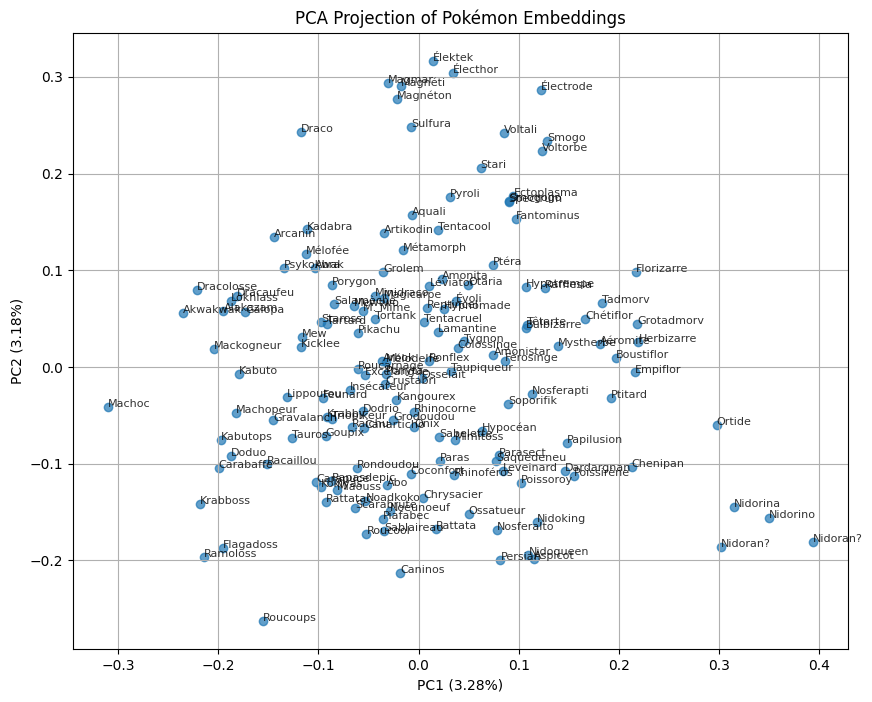

In [5]:
all_points = client.scroll(
    collection_name="pokemons",
    limit=10000,
    with_payload=True,
    with_vectors=True
)[0]
embeddings = []
ids = []
for point in all_points:
    embeddings.append(point.vector)
    ids.append(point.payload.get("nom", point.id))
embeddings = np.array(embeddings)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to %
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
for i, name in enumerate(ids):
    plt.annotate(name, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.8)
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
plt.title("PCA Projection of Pokémon Embeddings")
plt.grid(True)
plt.show()